In [72]:
%load_ext autoreload
%autoreload 2

import asyncio, copy, os, socket, sys, time
from functools import partial
from multiprocessing import Pool, Process
from pathlib import Path
from tqdm import tqdm

import torch
from torch import optim

import shap
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), "../../")))
from libs import agg, data, fl, log, nn, plot, poison, resnet, sim, wandb
from cfgs.fedargs import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [46]:
project = 'fl-shap'
name = 'fedavg-cnn-mnist'

#Define Custom CFGs
fedargs.num_clients = 10
mal_clients = [c for c in range(5)]
shap_explain["is"] = True

# Save Logs To File (info | debug | warning | error | critical) [optional]
log.init("info")
wb = wandb.init(name, project)

acc,▁▆▆▇▇▇███
epoch,▁▂▃▄▅▅▆▇█
loss,▁▂▄▅▆▇▇▇█
time,▁▁▅▅▅▅███
acc,74.67
epoch,9
loss,1.94514
time,1653658516.4391


wandb: wandb version 0.12.17 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [73]:
# Device settings
use_cuda = fedargs.cuda and torch.cuda.is_available()
torch.manual_seed(fedargs.seed)
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {"num_workers": 1, "pin_memory": True} if use_cuda else {}

In [74]:
# Prepare clients
host = socket.gethostname()
clients = [host + "(" + str(client + 1) + ")" for client in range(fedargs.num_clients)]

In [75]:
# Initialize Global and Client models
global_model = copy.deepcopy(fedargs.model)
# Load Data to clients
train_data, test_data = data.load_dataset(fedargs.dataset, only_to_tensor = True)

In [76]:
clients_data = data.split_data(train_data, clients)

<h1>SHAP: Trim Data For Class Sniffing</h1>

In [77]:
if shap_explain["is"]:
    for client in mal_clients:
        clients_data[clients[client]] = shap_explain["trim_data"](clients_data[clients[client]], shap_explain["trim_labels"])    

IndexError: list index out of range

In [78]:
client_train_loaders, _ = data.load_client_data(clients_data, fedargs.client_batch_size, None, **kwargs)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=fedargs.test_batch_size, shuffle=True, **kwargs)

client_details = {
        client: {"train_loader": client_train_loaders[client],
                 "model": copy.deepcopy(global_model),
                 "model_update": None}
        for client in clients
    }

In [79]:
def background(f):
    def wrapped(*args, **kwargs):
        return asyncio.get_event_loop().run_in_executor(None, f, *args, **kwargs)

    return wrapped

@background
def process(client, epoch, model, train_loader, fedargs, device):
    # Train
    model_update, model, loss = fedargs.train_func(model, train_loader, 
                                                   fedargs.learning_rate,
                                                   fedargs.weight_decay,
                                                   fedargs.local_rounds, device)

    log.jsondebug(loss, "Epoch {} of {} : Federated Training loss, Client {}".format(epoch, fedargs.epochs, client))
    log.modeldebug(model_update, "Epoch {} of {} : Client {} Update".format(epoch, fedargs.epochs, client))
    
    return model_update, model

In [54]:
import time
start_time = time.time()

fedargs.epochs = 10
    
# Federated Training
for epoch in tqdm(range(fedargs.epochs)):
    log.info("Federated Training Epoch {} of {}".format(epoch, fedargs.epochs))
    
    # Global Model Update
    if epoch > 0:     
        # Average
        global_model = fl.federated_avg(client_model_updates, global_model)
        log.modeldebug(global_model, "Epoch {} of {} : Server Update".format(epoch, fedargs.epochs))
        
        # Test and Log
        global_test_output = fedargs.eval_func(global_model, test_loader, device)
        wb.log({"epoch": epoch, "time": time.time(), "acc": global_test_output["accuracy"], "loss": global_test_output["test_loss"]})
        log.jsoninfo(global_test_output, "Global Test Outut after Epoch {} of {}".format(epoch, fedargs.epochs))
        
        # Update client models
        #for client in clients:
        #    client_details[client]['model'] = copy.deepcopy(global_model)

    # Clients
    tasks = [process(client, epoch, client_details[client]['model'],
                     client_details[client]['train_loader'],
                     fedargs, device) for client in clients]
    try:
        updates = fedargs.loop.run_until_complete(asyncio.gather(*tasks))
    except KeyboardInterrupt as e:
        log.error("Caught keyboard interrupt. Canceling tasks...")
        tasks.cancel()
        fedargs.loop.run_forever()
        tasks.exception()

    for client, (model_update, model) in zip(clients, updates):
        client_details[client]['model_update'], client_details[client]['model'] = model_update, model
    client_model_updates = {client: details["model_update"] for client, details in client_details.items()}

print(time.time() - start_time)

 10%|█         | 1/10 [00:24<03:42, 24.77s/it]2022-05-28 10:11:13,898 - <ipython-input-54-8efa5b355043>::<module>(l:8) : Federated Training Epoch 1 of 10 [MainProcess : MainThread (INFO)]
2022-05-28 10:11:15,808 - <ipython-input-54-8efa5b355043>::<module>(l:19) : Global Test Outut after Epoch 1 of 10 {
    "accuracy": 68.27,
    "correct": 6827,
    "test_loss": 1.1538332145690917
} [MainProcess : MainThread (INFO)]
 20%|██        | 2/10 [00:53<03:36, 27.04s/it]2022-05-28 10:11:42,517 - <ipython-input-54-8efa5b355043>::<module>(l:8) : Federated Training Epoch 2 of 10 [MainProcess : MainThread (INFO)]
2022-05-28 10:11:44,766 - <ipython-input-54-8efa5b355043>::<module>(l:19) : Global Test Outut after Epoch 2 of 10 {
    "accuracy": 71.53,
    "correct": 7153,
    "test_loss": 1.3452501658439637
} [MainProcess : MainThread (INFO)]
 30%|███       | 3/10 [01:22<03:15, 27.88s/it]2022-05-28 10:12:11,378 - <ipython-input-54-8efa5b355043>::<module>(l:8) : Federated Training Epoch 3 of 10 [MainP

284.15418696403503


<h1>SHAP Explain</h1>

In [80]:
print(clients[0])
print(fedargs.eval_func(client_details['bladecluster.iitp.org(1)']['model'], test_loader, device))

bladecluster.iitp.org(1)
{'test_loss': 2.3018545581817627, 'correct': 807, 'accuracy': 8.07}


In [82]:
batch = next(iter(test_loader))
images, labels = batch
baseline = images
    
explain1 = shap.DeepExplainer(client_details['bladecluster.iitp.org(1)']['model'], baseline)
explain2 = shap.DeepExplainer(client_details['bladecluster.iitp.org(9)']['model'], baseline)
explain3 = shap.DeepExplainer(global_model, baseline)
#explain = shap.DeepExplainer(global_model, baseline)

tensor(4)


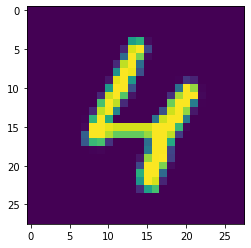

In [83]:
label = -1
while label != 4:
    batch = next(iter(test_loader))
    images, labels = batch
    g_img, label = images[0], labels[0]
    plt.imshow(g_img.numpy().squeeze())
    print(label)

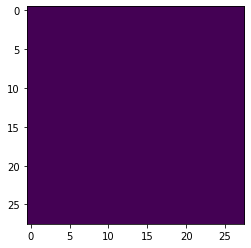

In [84]:
z_img = torch.tensor([[0.0 for col in range(28)] for row in range(28)])
z_img = z_img.reshape(1,28,28)
plt.imshow(z_img.numpy().squeeze())

In [85]:
def shap_plot(explain, img):
    #shap_image = g_img.unsqueeze(0)
    shap_values = explain.shap_values(img.unsqueeze(0))
    
    shap_tensor = torch.tensor(shap_values)
    shap_lists = []
    for i in range(10):
        lsum = 0
        lst = shap_tensor[i].squeeze(0).squeeze(0).view(784).tolist()
        shap_lists.append(lst)
        for l in lst:
            if l > 0:
                lsum += abs(l)
        print ('shap_sum', lsum)
    
    shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
    test_numpy = np.swapaxes(np.swapaxes(img.unsqueeze(0).numpy(), 1, -1), 1, 2)
    shap.image_plot(shap_numpy, -test_numpy, None, 20, 0.2, 0.2, None, False)
    #shap.image_plot(shap_values, -shap_image)

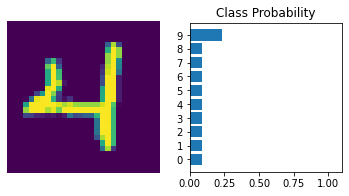

In [60]:
from torch.nn import functional as F

def view_classify(img, ps, version="MNIST"):
    ps = ps.data.numpy().squeeze()    
    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    if version == "MNIST":
        ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    
model = client_details['bladecluster.iitp.org(5)']['model']
with torch.no_grad():
    logits = model.forward(g_img.unsqueeze(0).float())

ps = F.softmax(logits, dim=1)
_, label = torch.max(ps, 1)
view_classify(g_img, ps)

shap_sum 0.4502154216883304
shap_sum 0.015116594338768552
shap_sum 0.00506737698089843
shap_sum 0.004260100556057481
shap_sum 0.0034508761347259442
shap_sum 0.009187540137892247
shap_sum 0.08205324585229024
shap_sum 0.008439859575040565
shap_sum 0.006563029506585938
shap_sum 0.013560298996455611


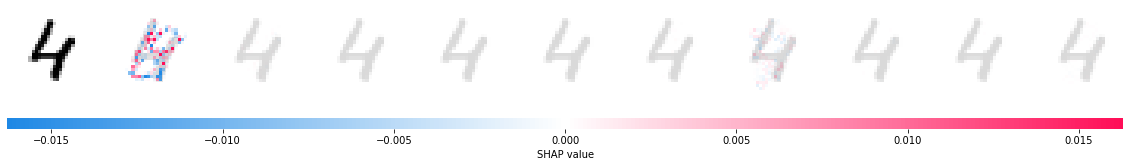

In [86]:
shap_plot(explain1, g_img)

shap_sum 0.4502154216883304
shap_sum 0.015116594338768552
shap_sum 0.00506737698089843
shap_sum 0.004260100556057481
shap_sum 0.0034508761347259442
shap_sum 0.009187540137892247
shap_sum 0.08205324585229024
shap_sum 0.008439859575040565
shap_sum 0.006563029506585938
shap_sum 0.013560298996455611


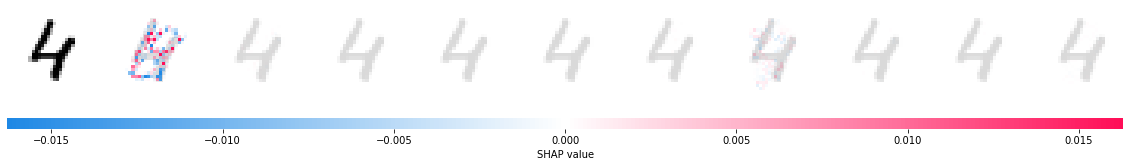

In [87]:
shap_plot(explain2, g_img)

shap_sum 0.0033930309704864325
shap_sum 0.005498696787108237
shap_sum 0.01705057742571925
shap_sum 0.005311099427531343
shap_sum 0.003631372202240357
shap_sum 0.031484769618494
shap_sum 0.0040595860811695195
shap_sum 0.0037196882952157395
shap_sum 0.01077791713903875
shap_sum 0.03588862750342159


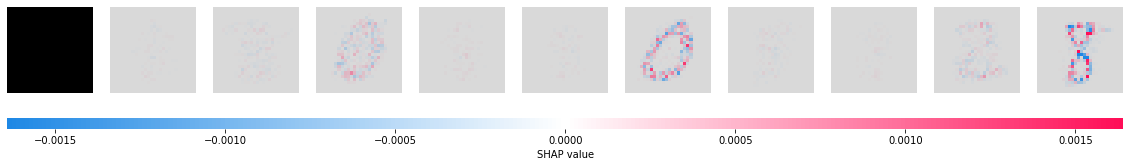

In [88]:
shap_plot(explain1, z_img)

shap_sum 3.587634623562552
shap_sum 0.2313174563753272
shap_sum 0.053723148169460444
shap_sum 0.11618033124601546
shap_sum 0.6545084579478306
shap_sum 0.23735020234672177
shap_sum 0.1416884733938334
shap_sum 3.690212449069702
shap_sum 0.018714789381543473
shap_sum 0.06528847631150869


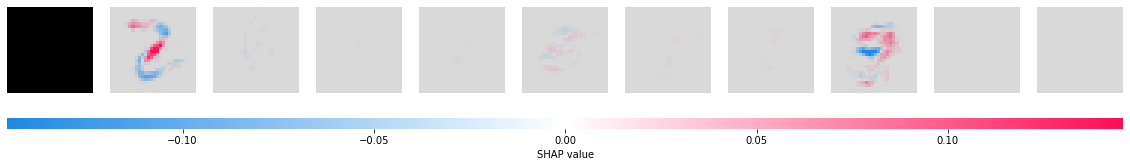

In [64]:
shap_plot(explain2, z_img)

<h1> End </h1>